# 🌍 Qartezator: Yet another aerial image-to-map translator

## Environment setup

First you need to install qartezator from project root directory

In [1]:
!git clone https://github.com/AndranikSargsyan/qartezator.git

Cloning into 'qartezator'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 72 (delta 25), reused 64 (delta 21), pack-reused 0
Unpacking objects: 100% (72/72), 977.15 KiB | 2.58 MiB/s, done.


In [2]:
%cd qartezator

/content/qartezator


In [3]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/qartezator
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.2 M

In [4]:
!gdown https://drive.google.com/uc?id=1nq4yAQ5HSVOGL5B2juPU_L5WElKKVBPj
!unzip data.zip;

Downloading...
From: https://drive.google.com/uc?id=1nq4yAQ5HSVOGL5B2juPU_L5WElKKVBPj
To: /content/qartezator/data.zip
100% 413M/413M [00:06<00:00, 60.3MB/s]
Archive:  data.zip
   creating: data/
   creating: data/maps/
   creating: data/maps/test/
  inflating: data/maps/test/1.jpg    
  inflating: data/maps/test/10.jpg   
  inflating: data/maps/test/100.jpg  
  inflating: data/maps/test/1001.jpg  
  inflating: data/maps/test/1002.jpg  
  inflating: data/maps/test/1003.jpg  
  inflating: data/maps/test/1004.jpg  
  inflating: data/maps/test/1005.jpg  
  inflating: data/maps/test/1007.jpg  
  inflating: data/maps/test/1008.jpg  
  inflating: data/maps/test/1009.jpg  
  inflating: data/maps/test/101.jpg  
  inflating: data/maps/test/1010.jpg  
  inflating: data/maps/test/1011.jpg  
  inflating: data/maps/test/1012.jpg  
  inflating: data/maps/test/1013.jpg  
  inflating: data/maps/test/1014.jpg  
  inflating: data/maps/test/1015.jpg  
  inflating: data/maps/test/1016.jpg  
  inflating: d

## Setup Dataloaders

In [5]:
import torch
from PIL import Image

from qartezator.data.dataset import QartezatorDataset
from qartezator.data.datamodule import QartezatorDataModule
from qartezator.data.transforms import get_common_augmentations

In [6]:
root_path = './data/maps'
train_txt_path = './assets/train.txt'
val_txt_path = './assets/val.txt'
test_txt_path = './assets/test.txt'

In [7]:
ds = QartezatorDataset(
    root_path=root_path,
    split_file_path=train_txt_path,
    common_transform=get_common_augmentations(256)
)
sample_source_img, sample_target_img = ds[42]

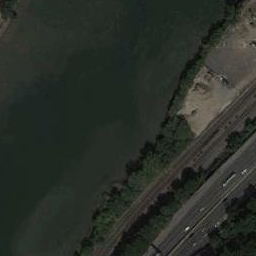

In [8]:
Image.fromarray(sample_source_img)

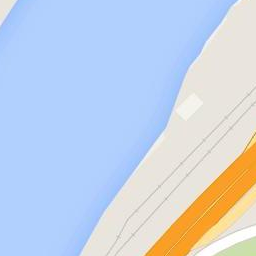

In [9]:
Image.fromarray(sample_target_img)

In [10]:
dm = QartezatorDataModule(
    root_path=root_path,
    train_txt_path=train_txt_path,
    val_txt_path=val_txt_path,
    test_txt_path=test_txt_path,
    input_size=256
)
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
for batch in train_dataloader:
    source, target = batch
    print(f'Source batch shape: {source.shape}')
    print(f'Target batch shape: {target.shape}\n')
    break

Source batch shape: torch.Size([32, 3, 256, 256])
Target batch shape: torch.Size([32, 3, 256, 256])



In [12]:
len(train_dataloader.dataset)

2792

In [13]:
len(val_dataloader.dataset)

250

In [14]:
len(test_dataloader.dataset)

250